In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_025_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_025_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_17 (Activation)   (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_38 (Activation)   (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.4282 - acc: 0.2418
Epoch 00001: val_loss improved from inf to 2.23360, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_1_conv_checkpoint/001-2.2336.hdf5
36805/36805 [==============================] - 29s 778us/sample - loss: 2.4276 - acc: 0.2420 - val_loss: 2.2336 - val_acc: 0.3103
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9447 - acc: 0.4217
Epoch 00002: val_loss improved from 2.23360 to 2.13350, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_1_conv_checkpoint/002-2.1335.hdf5
36805/36805 [==============================] - 27s 720us/sample - loss: 1.9447 - acc: 0.4217 - val_loss: 2.1335 - val_acc: 0.3433
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6358 - acc: 0.5275
Epoch 00003: val_loss improved from 2.13350 to 2.13169, saving mo

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9943
Epoch 00029: val_loss did not improve from 2.13169
36805/36805 [==============================] - 26s 716us/sample - loss: 0.0744 - acc: 0.9943 - val_loss: 4.3078 - val_acc: 0.3175
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0739 - acc: 0.9932
Epoch 00030: val_loss did not improve from 2.13169
36805/36805 [==============================] - 26s 714us/sample - loss: 0.0739 - acc: 0.9932 - val_loss: 4.3813 - val_acc: 0.3100
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9944
Epoch 00031: val_loss did not improve from 2.13169
36805/36805 [==============================] - 26s 714us/sample - loss: 0.0702 - acc: 0.9944 - val_loss: 4.4108 - val_acc: 0.3110
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0582 - acc: 0.9966
Epoch 00032: val_loss did not improve from 2.13169
36805/36805 [=====

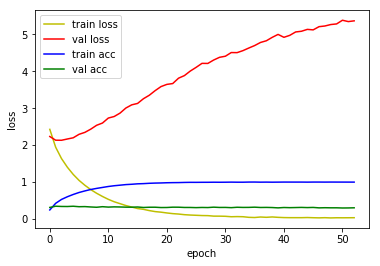

4815/4815 [==============================] - 2s 336us/sample - loss: 2.1682 - acc: 0.3180
Loss: 2.168214232453676 Accuracy: 0.3179647

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2100 - acc: 0.3166
Epoch 00001: val_loss improved from inf to 1.91000, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_2_conv_checkpoint/001-1.9100.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 2.2100 - acc: 0.3166 - val_loss: 1.9100 - val_acc: 0.4323
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7240 - acc: 0.4803
Epoch 00002: val_loss improved from 1.91000 to 1.76283, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_2_conv_checkpoint/002-1.7628.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 1.7240 - acc: 0.4803 - val_loss: 1.7628 - val_acc: 0.4533
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4

36800/36805 [============================>.] - ETA: 0s - loss: 0.0501 - acc: 0.9937
Epoch 00029: val_loss did not improve from 1.76283
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0501 - acc: 0.9937 - val_loss: 4.1215 - val_acc: 0.4177
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0589 - acc: 0.9907
Epoch 00030: val_loss did not improve from 1.76283
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0589 - acc: 0.9907 - val_loss: 4.1092 - val_acc: 0.4214
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9930
Epoch 00031: val_loss did not improve from 1.76283
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0490 - acc: 0.9930 - val_loss: 4.1634 - val_acc: 0.4195
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9919
Epoch 00032: val_loss did not improve from 1.76283
36805/36805 [========================

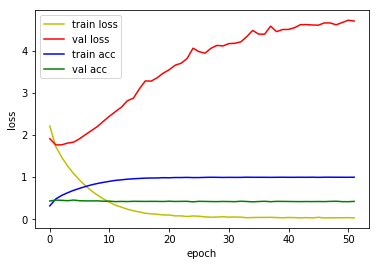

4815/4815 [==============================] - 2s 511us/sample - loss: 1.8190 - acc: 0.4372
Loss: 1.8189863257690382 Accuracy: 0.43717548

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1063 - acc: 0.3402
Epoch 00001: val_loss improved from inf to 1.70830, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_3_conv_checkpoint/001-1.7083.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 2.1063 - acc: 0.3402 - val_loss: 1.7083 - val_acc: 0.4684
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5142 - acc: 0.5370
Epoch 00002: val_loss improved from 1.70830 to 1.47613, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_3_conv_checkpoint/002-1.4761.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.5142 - acc: 0.5370 - val_loss: 1.4761 - val_acc: 0.5453
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

36800/36805 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9837
Epoch 00029: val_loss did not improve from 1.39836
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0744 - acc: 0.9838 - val_loss: 2.8836 - val_acc: 0.5644
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9855
Epoch 00030: val_loss did not improve from 1.39836
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0683 - acc: 0.9855 - val_loss: 2.9596 - val_acc: 0.5600
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0721 - acc: 0.9845
Epoch 00031: val_loss did not improve from 1.39836
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0721 - acc: 0.9845 - val_loss: 2.9512 - val_acc: 0.5656
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0721 - acc: 0.9852
Epoch 00032: val_loss did not improve from 1.39836
36805/36805 [========================

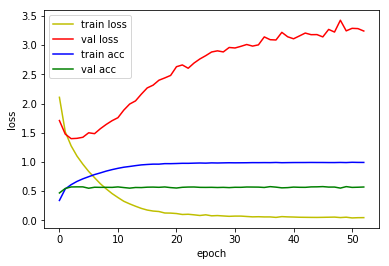

4815/4815 [==============================] - 3s 564us/sample - loss: 1.4685 - acc: 0.5448
Loss: 1.4684951744842134 Accuracy: 0.544756

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0680 - acc: 0.3364
Epoch 00001: val_loss improved from inf to 1.61552, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_4_conv_checkpoint/001-1.6155.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.0679 - acc: 0.3364 - val_loss: 1.6155 - val_acc: 0.4910
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4854 - acc: 0.5368
Epoch 00002: val_loss improved from 1.61552 to 1.37317, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_4_conv_checkpoint/002-1.3732.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.4855 - acc: 0.5368 - val_loss: 1.3732 - val_acc: 0.5751
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0888 - acc: 0.9746
Epoch 00028: val_loss did not improve from 1.11606
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0888 - acc: 0.9747 - val_loss: 1.7651 - val_acc: 0.6851
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0844 - acc: 0.9762
Epoch 00029: val_loss did not improve from 1.11606
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0844 - acc: 0.9762 - val_loss: 1.8047 - val_acc: 0.6837
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0793 - acc: 0.9779
Epoch 00030: val_loss did not improve from 1.11606
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0793 - acc: 0.9779 - val_loss: 1.8812 - val_acc: 0.6746
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0796 - acc: 0.9775
Epoch 00031: val_loss did not improve from 1.11606
36805/36805 [===========


1D_CNN_custom_DO_025_DO_4_conv Model


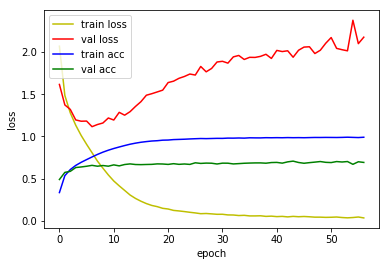

4815/4815 [==============================] - 3s 571us/sample - loss: 1.2187 - acc: 0.6125
Loss: 1.2187385915719584 Accuracy: 0.61246103

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0393 - acc: 0.3370
Epoch 00001: val_loss improved from inf to 1.53422, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_5_conv_checkpoint/001-1.5342.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.0392 - acc: 0.3369 - val_loss: 1.5342 - val_acc: 0.5134
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4742 - acc: 0.5378
Epoch 00002: val_loss improved from 1.53422 to 1.33505, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_5_conv_checkpoint/002-1.3350.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.4741 - acc: 0.5378 - val_loss: 1.3350 - val_acc: 0.5812
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

36800/36805 [============================>.] - ETA: 0s - loss: 0.1193 - acc: 0.9645
Epoch 00027: val_loss did not improve from 0.82417
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1193 - acc: 0.9645 - val_loss: 1.1650 - val_acc: 0.7643
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0971 - acc: 0.9718
Epoch 00028: val_loss did not improve from 0.82417
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0971 - acc: 0.9719 - val_loss: 1.2045 - val_acc: 0.7584
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0935 - acc: 0.9730
Epoch 00029: val_loss did not improve from 0.82417
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0935 - acc: 0.9730 - val_loss: 1.1983 - val_acc: 0.7643
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0966 - acc: 0.9713
Epoch 00030: val_loss did not improve from 0.82417
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9883
Epoch 00057: val_loss did not improve from 0.82417
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0434 - acc: 0.9883 - val_loss: 1.4624 - val_acc: 0.7738
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9883
Epoch 00058: val_loss did not improve from 0.82417
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0462 - acc: 0.9883 - val_loss: 1.4469 - val_acc: 0.7794
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9870
Epoch 00059: val_loss did not improve from 0.82417
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0474 - acc: 0.9870 - val_loss: 1.3596 - val_acc: 0.7808
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9886
Epoch 00060: val_loss did not improve from 0.82417
36805/36805 [===========

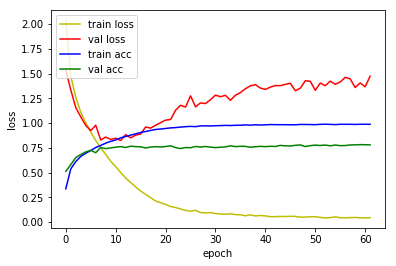

4815/4815 [==============================] - 3s 612us/sample - loss: 0.9344 - acc: 0.7240
Loss: 0.9344190928794884 Accuracy: 0.7239875

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1363 - acc: 0.3000
Epoch 00001: val_loss improved from inf to 1.57198, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_6_conv_checkpoint/001-1.5720.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.1363 - acc: 0.3000 - val_loss: 1.5720 - val_acc: 0.4805
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4981 - acc: 0.5197
Epoch 00002: val_loss improved from 1.57198 to 1.35421, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_6_conv_checkpoint/002-1.3542.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.4983 - acc: 0.5197 - val_loss: 1.3542 - val_acc: 0.5833
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2289 - acc: 0.9283
Epoch 00024: val_loss did not improve from 0.42253
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2289 - acc: 0.9283 - val_loss: 0.4372 - val_acc: 0.8884
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2119 - acc: 0.9340
Epoch 00025: val_loss did not improve from 0.42253
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2119 - acc: 0.9341 - val_loss: 0.4502 - val_acc: 0.8845
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2027 - acc: 0.9361
Epoch 00026: val_loss did not improve from 0.42253
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2026 - acc: 0.9361 - val_loss: 0.4604 - val_acc: 0.8847
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1977 - acc: 0.9381
Epoch 00027: val_loss did not improve from 0.42253
36805/36805 [===========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0579 - acc: 0.9818
Epoch 00054: val_loss did not improve from 0.42253
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0580 - acc: 0.9817 - val_loss: 0.5947 - val_acc: 0.8947
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9787
Epoch 00055: val_loss did not improve from 0.42253
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0671 - acc: 0.9787 - val_loss: 0.5870 - val_acc: 0.8966
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.9845
Epoch 00056: val_loss did not improve from 0.42253
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0514 - acc: 0.9845 - val_loss: 0.5848 - val_acc: 0.8991
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9843
Epoch 00057: val_loss did not improve from 0.42253
36805/36805 [===========

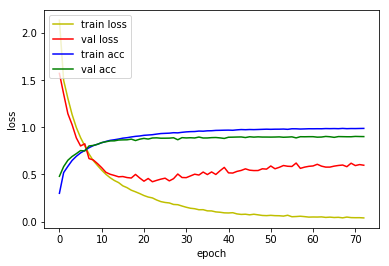

4815/4815 [==============================] - 3s 612us/sample - loss: 0.5109 - acc: 0.8534
Loss: 0.5109496772970118 Accuracy: 0.8533749

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2760 - acc: 0.2496
Epoch 00001: val_loss improved from inf to 1.60642, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_7_conv_checkpoint/001-1.6064.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.2760 - acc: 0.2496 - val_loss: 1.6064 - val_acc: 0.4864
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4725 - acc: 0.5233
Epoch 00002: val_loss improved from 1.60642 to 1.19392, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_7_conv_checkpoint/002-1.1939.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.4727 - acc: 0.5233 - val_loss: 1.1939 - val_acc: 0.6373
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

36800/36805 [============================>.] - ETA: 0s - loss: 0.2031 - acc: 0.9356
Epoch 00024: val_loss improved from 0.22713 to 0.21479, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_7_conv_checkpoint/024-0.2148.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2031 - acc: 0.9356 - val_loss: 0.2148 - val_acc: 0.9404
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1930 - acc: 0.9361
Epoch 00025: val_loss did not improve from 0.21479
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1929 - acc: 0.9361 - val_loss: 0.2174 - val_acc: 0.9415
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9384
Epoch 00026: val_loss did not improve from 0.21479
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1857 - acc: 0.9384 - val_loss: 0.2280 - val_acc: 0.9366
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1740 - acc:

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0685 - acc: 0.9775
Epoch 00053: val_loss did not improve from 0.20899
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0684 - acc: 0.9775 - val_loss: 0.2397 - val_acc: 0.9432
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0703 - acc: 0.9760
Epoch 00054: val_loss did not improve from 0.20899
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0703 - acc: 0.9760 - val_loss: 0.2349 - val_acc: 0.9492
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0678 - acc: 0.9769
Epoch 00055: val_loss did not improve from 0.20899
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0678 - acc: 0.9769 - val_loss: 0.2401 - val_acc: 0.9481
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0643 - acc: 0.9783
Epoch 00056: val_loss did not improve from 0.20899
36805/36805 [===========

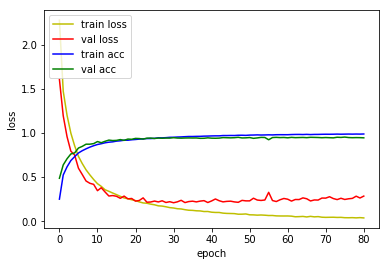

4815/4815 [==============================] - 3s 643us/sample - loss: 0.2688 - acc: 0.9219
Loss: 0.26882620208112373 Accuracy: 0.9219107

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1481 - acc: 0.2992
Epoch 00001: val_loss improved from inf to 1.33855, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_8_conv_checkpoint/001-1.3385.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.1480 - acc: 0.2993 - val_loss: 1.3385 - val_acc: 0.5786
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2152 - acc: 0.6083
Epoch 00002: val_loss improved from 1.33855 to 0.85332, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_8_conv_checkpoint/002-0.8533.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.2152 - acc: 0.6083 - val_loss: 0.8533 - val_acc: 0.7242
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1517 - acc: 0.9505
Epoch 00024: val_loss did not improve from 0.15314
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1516 - acc: 0.9506 - val_loss: 0.1666 - val_acc: 0.9525
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1399 - acc: 0.9542
Epoch 00025: val_loss did not improve from 0.15314
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1399 - acc: 0.9542 - val_loss: 0.1602 - val_acc: 0.9509
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1338 - acc: 0.9555
Epoch 00026: val_loss did not improve from 0.15314
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1338 - acc: 0.9555 - val_loss: 0.1685 - val_acc: 0.9497
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1300 - acc: 0.9566
Epoch 00027: val_loss did not improve from 0.15314
36805/36805 [===========

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9839
Epoch 00053: val_loss did not improve from 0.14403
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0489 - acc: 0.9839 - val_loss: 0.1664 - val_acc: 0.9592
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9837
Epoch 00054: val_loss did not improve from 0.14403
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0467 - acc: 0.9837 - val_loss: 0.1653 - val_acc: 0.9592
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9842
Epoch 00055: val_loss did not improve from 0.14403
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0448 - acc: 0.9842 - val_loss: 0.1526 - val_acc: 0.9611
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9855
Epoch 00056: val_loss did not improve from 0.14403
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9918
Epoch 00083: val_loss did not improve from 0.14403
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0237 - acc: 0.9918 - val_loss: 0.1880 - val_acc: 0.9655
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9912
Epoch 00084: val_loss did not improve from 0.14403
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0280 - acc: 0.9913 - val_loss: 0.1944 - val_acc: 0.9592
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9925
Epoch 00085: val_loss did not improve from 0.14403
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0212 - acc: 0.9925 - val_loss: 0.2018 - val_acc: 0.9592
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9918
Epoch 00086: val_loss did not improve from 0.14403
36805/36805 [===========

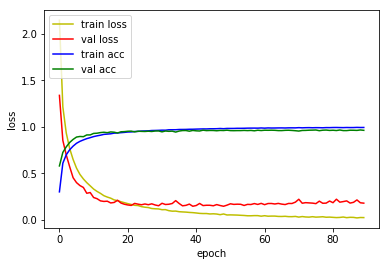

4815/4815 [==============================] - 3s 663us/sample - loss: 0.2084 - acc: 0.9458
Loss: 0.2084455304575053 Accuracy: 0.9457944

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9580 - acc: 0.3707
Epoch 00001: val_loss improved from inf to 1.10654, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_9_conv_checkpoint/001-1.1065.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.9581 - acc: 0.3706 - val_loss: 1.1065 - val_acc: 0.6534
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9523 - acc: 0.6893
Epoch 00002: val_loss improved from 1.10654 to 0.69446, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_9_conv_checkpoint/002-0.6945.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9523 - acc: 0.6893 - val_loss: 0.6945 - val_acc: 0.7780
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0749 - acc: 0.9746
Epoch 00025: val_loss did not improve from 0.15292
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0749 - acc: 0.9746 - val_loss: 0.1700 - val_acc: 0.9518
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9771
Epoch 00026: val_loss did not improve from 0.15292
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0678 - acc: 0.9771 - val_loss: 0.1699 - val_acc: 0.9532
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0654 - acc: 0.9777
Epoch 00027: val_loss did not improve from 0.15292
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0654 - acc: 0.9777 - val_loss: 0.1727 - val_acc: 0.9529
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9792
Epoch 00028: val_loss did not improve from 0.15292
36805/36805 [========================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9918
Epoch 00055: val_loss did not improve from 0.15292
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0248 - acc: 0.9918 - val_loss: 0.2165 - val_acc: 0.9546
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9928
Epoch 00056: val_loss did not improve from 0.15292
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0225 - acc: 0.9928 - val_loss: 0.2168 - val_acc: 0.9555
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0223 - acc: 0.9926
Epoch 00057: val_loss did not improve from 0.15292
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0223 - acc: 0.9926 - val_loss: 0.2037 - val_acc: 0.9560
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.9934
Epoch 00058: val_loss did not improve from 0.15292
36805/36805 [===========

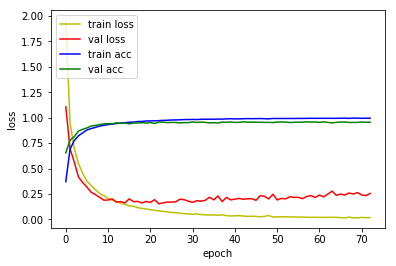

4815/4815 [==============================] - 3s 684us/sample - loss: 0.2600 - acc: 0.9292
Loss: 0.25997866053571334 Accuracy: 0.92917967



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_DO_025_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_025_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_DO_025_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_025_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 398us/sample - loss: 2.1682 - acc: 0.3180
Lo

4815/4815 [==============================] - 3s 666us/sample - loss: 0.9344 - acc: 0.7240
Loss: 0.9344190928794884 Accuracy: 0.7239875

1D_CNN_custom_DO_025_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None,

4815/4815 [==============================] - 4s 732us/sample - loss: 0.2084 - acc: 0.9458
Loss: 0.2084455304575053 Accuracy: 0.9457944

1D_CNN_custom_DO_025_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_81 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_82 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None,